In [ ]:
#!pip install xlearn -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.sparse import hstack
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split

import xlearn as xl
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss, roc_auc_score

In [2]:
# global variables
PATH_TO_FOLDER_WITH_DATA = 'data/'
PATH_TO_DATA_FILE : str = PATH_TO_FOLDER_WITH_DATA+'data.csv' # путь к файлу с данными

In [ ]:
data = pd.read_csv(PATH_TO_DATA_FILE)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [ ]:
# удаляю столбцы, не используемые в данном задании
data = data.drop(columns = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


In [ ]:
def analysis(data: pd.DataFrame):
    # проверяем, есть ли в таблице null, если да -- то в каких столбцах и в каком количестве
    null_columns=data.columns[data.isnull().any()]
    if len(null_columns) == 0:
      print("Dataframe does not consists null values")
    else:
      print("Number of null rows in columns")
      print(data[null_columns].isnull().sum())

    print("\n")

    # посмотрим на то, сколько уникальных значений в каждом столбце
    columns = data.columns.values.tolist()
    columns.remove('date_time')
    columns.remove('oaid_hash')
    for column_name in columns:
      unique_column_values = data[column_name].unique()
      print(f"count of unique values in column {column_name} = {len(unique_column_values)}")
      print("distribution of values:")
      data[column_name].hist()
      plt.show()
      print("\n")
    
    print("\n")

    # проверим разброс значений в столбце campaign_clicks
    print("in column campaign_clicks ")
    print(f"max value = {data.campaign_clicks.max()}")
    print(f"min value = {data.campaign_clicks.min()}")
    print(f"mean = {data.campaign_clicks.mean()}")
    print(f"median = {data.campaign_clicks.median()}")
    
    print("\n")


    # приведу date_time столбец к нужному типу
    data['date_time'] = pd.to_datetime(data['date_time'], format = "%Y-%m-%d %H:%M:%S.%f")

    # проверим, о каком периоде у нас собраны данные
    data['date'] = data['date_time'].dt.date
    days = data['date'].unique()
    print(f"we have info about {len(days)} days. The count of rows for each day:")
    print(data['date'].value_counts())
    # в данном наборе такой проверки достаточно, т.к. рассматриваем данные взяты из небольшого диапазона
    # если бы данных было больше, то я бы проанализировала также, к каким годам и месяцам относятся данные

    print("\n")

    # тут проверяю, обо всех ли часах в днях есть данные
    data['hour'] = data['date_time'].dt.hour
    hours = data['hour'].unique()
    if len(hours) < 24:
      print(f"We have info only about {len(hours)} hours in days")

    print("\n")
    
    # узнать распределение классов
    classes_count = data['clicks'].value_counts()
    print("Count of rows into each class")
    print(classes_count)
    print(f"ratio of class 0 to class 1 {classes_count[0]/classes_count[1]}")

Total count of users = 6510316
Min count of info about single user = 1
Max count of info about single user = 5243
Mean count of info about single user = 2.430215676166871
Median count of info about single user = 1.0
destribution of count of rows for each user:


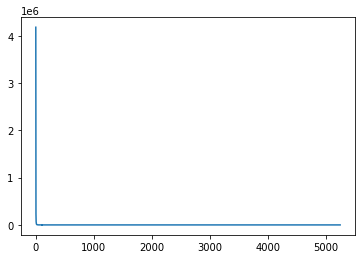



4182814 users nave 1 row


In [ ]:
# проверим, сколько записей в среднем есть о каждом пользователе
unique_users = data['oaid_hash'].unique()
print(f"Total count of users = {unique_users.shape[0]}")
rows_for_users_count = data['oaid_hash'].value_counts()
print(f"Min count of info about single user = {rows_for_users_count.min()}")
print(f"Max count of info about single user = {rows_for_users_count.max()}")
print(f"Mean count of info about single user = {rows_for_users_count.mean()}")
print(f"Median count of info about single user = {rows_for_users_count.median()}")
print("destribution of count of rows for each user:")
rows_for_users_count.value_counts().plot()
plt.show()
print("\n")

print(f"{rows_for_users_count[rows_for_users_count==1].shape[0]} users nave 1 row")

del unique_users

У нас добавился один столбец -- хэш пользователя

Анализ показал, что о большей части пользователей мы имеем всего несколько записей. Такие пользователи дают очень мало информации. Удалим их из рассмотрения 

In [ ]:
oaids_to_delete = rows_for_users_count[rows_for_users_count==1].index
data = data[~data['oaid_hash'].isin(oaids_to_delete)]

del rows_for_users_count
del oaids_to_delete

Dataframe does not consists null values


count of unique values in column zone_id = 2423
distribution of values:


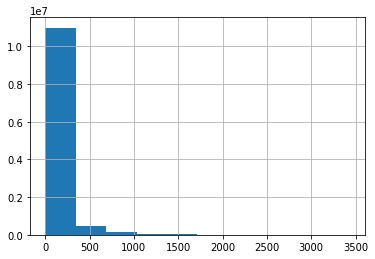



count of unique values in column banner_id = 1395
distribution of values:


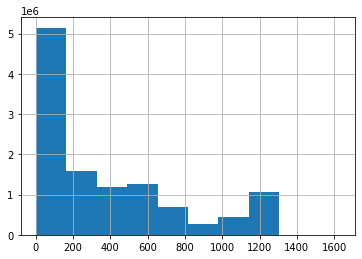



count of unique values in column campaign_clicks = 822
distribution of values:


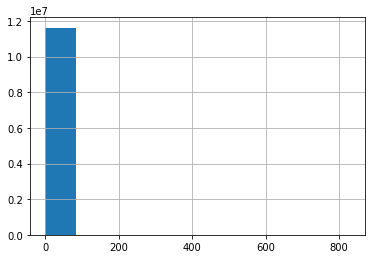



count of unique values in column os_id = 11
distribution of values:


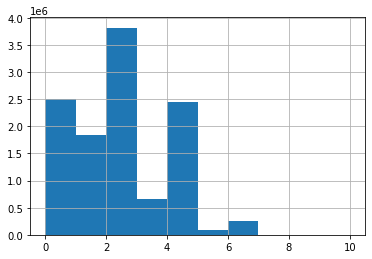



count of unique values in column country_id = 17
distribution of values:


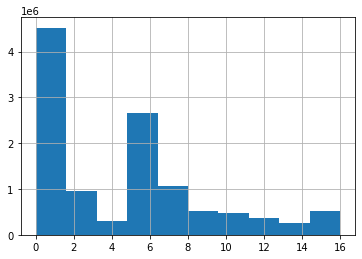



count of unique values in column impressions = 1
distribution of values:


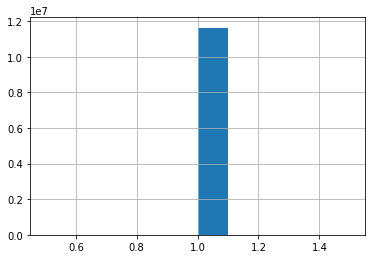



count of unique values in column clicks = 2
distribution of values:


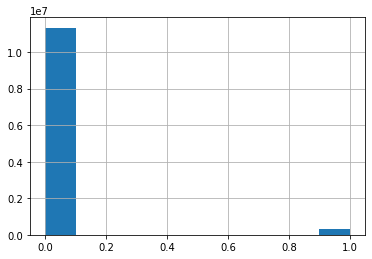





in column campaign_clicks 
max value = 829
min value = 0
mean = 0.8470579683671433
median = 0.0


we have info about 7 days. The count of rows for each day:
2021-09-26    2338297
2021-09-27    1770442
2021-09-28    1742257
2021-09-29    1741910
2021-10-02    1527001
2021-09-30    1326790
2021-10-01    1191961
Name: date, dtype: int64




Count of rows into each class
0    11332706
1      305952
Name: clicks, dtype: int64
ratio of class 0 to class 1 37.04079724924171


In [ ]:
analysis(data)

Препроцессинг выполним аналогичный тому, что был сделан в прошлом дз. 

Однако, не будем объединять редкие значения столбцов в одну категорию, а удалим (подумав, мне все же кажется странным не зная природы данных объединять их в одну группу).

In [ ]:
def preproc_data(data: pd.DataFrame) -> pd.DataFrame:

    data = data.drop(columns = ['impressions'])

    data['date_time'] = pd.to_datetime(data['date_time'], format = "%Y-%m-%d %H:%M:%S.%f")
    data['date'] = data['date_time'].dt.date.astype('str')
    data['hour'] = data['date_time'].dt.hour

    data = data.drop(columns = ['date_time'])

    # нормализуем campaign_clicks
    scaler = preprocessing.MinMaxScaler().fit(data[['campaign_clicks']])
    data['campaign_clicks'] = scaler.transform(data[['campaign_clicks']])  

    # удалим встречающиеся редко значения в столбцах с большим количеством возможных значений
    column_values_count = data['zone_id'].value_counts()
    qua = column_values_count.quantile(0.4)
    values_to_delete = column_values_count[column_values_count<=qua].index
    data = data[~data['zone_id'].isin(values_to_delete)]

    column_values_count = data['banner_id'].value_counts()
    qua = column_values_count.quantile(0.2)
    values_to_delete = column_values_count[column_values_count<=qua].index
    data = data[~data['banner_id'].isin(values_to_delete)]


    train_data = data[~data['date'].isin(['2021-10-01', '2021-10-02'])].drop(columns=['date'])
    valid_data =data[data['date'] == '2021-10-01'].drop(columns=['date']) 
    test_data = data[data['date'] == '2021-10-02'].drop(columns=['date'])

    del data
        
    return train_data, valid_data, test_data   

In [ ]:
train_data, valid_data, test_data = preproc_data(data)
del data

Код для конвертации в нужный формат взят [тут](https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py)

(и подсмотрен в [туториале](https://wngaw.github.io/field-aware-factorization-machines-with-xlearn/))

In [ ]:
def convert_to_ffm(encoder, path, df, type,
                   target = 'clicks', num_cols = ['campaign_clicks'], 
                   cat_cols = ['zone_id', 'banner_id', 'os_id', 'country_id', 'hour', 'oaid_hash']):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in num_cols:
        if x not in encoder['catdict']:
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in cat_cols:
        if x not in encoder['catdict']:
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(range(nrows)):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:
                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    return encoder

Удалила вывод ячейки ниже, тк не несет сильной смысловой нагрузки для задания

In [ ]:
encoder = {"currentcode": 1,
           "catdict": {},
           "catcodes": {}}
encoder = convert_to_ffm(encoder, PATH_TO_FOLDER_WITH_DATA, train_data, 'train')
encoder = convert_to_ffm(encoder, PATH_TO_FOLDER_WITH_DATA, valid_data, 'valid')
encoder = convert_to_ffm(encoder, PATH_TO_FOLDER_WITH_DATA, test_data, 'test')

In [3]:
PATH_TO_TRAIN = PATH_TO_FOLDER_WITH_DATA+'train_ffm.txt'
PATH_TO_VALID =PATH_TO_FOLDER_WITH_DATA+'valid_ffm.txt'
PATH_TO_TEST = PATH_TO_FOLDER_WITH_DATA+'test_ffm.txt'
PATH_MODEL_DOT_OUT = PATH_TO_FOLDER_WITH_DATA+'model.out'
PATH_MODEL_OUTPUT = PATH_TO_FOLDER_WITH_DATA+'output.txt'

In [4]:
def cv(param):
  print("========================================================")
  print(param)
  print("========================================================")
  ffm_model = xl.create_ffm()    
  ffm_model.setTrain(PATH_TO_TRAIN)     
  ffm_model.setValidate(PATH_TO_VALID)
  ffm_model.fit(param, PATH_MODEL_DOT_OUT)
  print("fitting done")

  ffm_model.setTest(PATH_TO_VALID)  
  ffm_model.setSigmoid()        
  ffm_model.predict(PATH_MODEL_DOT_OUT, PATH_MODEL_OUTPUT)

  with open(PATH_MODEL_OUTPUT) as f:
    predictions = f.readlines()

  with open(PATH_TO_VALID) as f:
    truths = f.readlines()
  truths = np.array([float(truth.split(' ')[0]) for truth in truths])
  predictions = np.array([float(prediction.strip('')) for prediction in predictions])
  log_los_for_model = log_loss(truths, predictions)
  roc_auc_for_model = roc_auc_score(truths, predictions)
  print("========================================================")
  print(f"roc auc = {roc_auc_for_model}; log-loss = {log_los_for_model}")
  print("========================================================")
    
    

In [5]:
import os
os.environ['USER'] = 'xlearn'

т.к. у меня не хватает мощностей, буду запускать каждый набор параметров в отдельной ячейке (чтоб не падал kernel)

In [6]:
# какие наборы мне нужно проверить
params = {
        "task" : ['binary'], 
        "lr" : [0.01, 0.1],
        "lambda" : [0.00001, 0.0001],
        "k" : [4, 6],
        "epoch" : [10],
        'metric': ['auc']
    }
for param in ParameterGrid(params):
    print("========================================================")
    print(param)
    print("========================================================")

{'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
{'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}


In [5]:
cv({'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[----------

In [5]:
cv({'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 4, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[-----------

In [6]:
cv({'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[---------

In [5]:
cv({'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 4, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[----------

In [5]:
cv({'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[----------

In [7]:
cv({'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[-----------

In [6]:
cv({'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.01, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[---------

In [6]:
cv({'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'})

{'epoch': 10, 'k': 6, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[----------

получим результат на лучшей модели для тестовой выборки

In [4]:
best_params = {'epoch': 10, 'k': 6, 'lambda': 1e-05, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}

ffm_model = xl.create_ffm()    
ffm_model.setTrain(PATH_TO_TRAIN)     
ffm_model.setValidate(PATH_TO_VALID)
ffm_model.fit(best_params, PATH_MODEL_DOT_OUT)

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[------------] Number of Field: 7
[------------] Time cost for reading problem: 9.34 (sec)
[ ACTI

In [5]:
ffm_model.setTest(PATH_TO_TEST)  
ffm_model.setSigmoid()        
ffm_model.predict(PATH_MODEL_DOT_OUT, PATH_MODEL_OUTPUT)

with open(PATH_MODEL_OUTPUT) as f:
    predictions = f.readlines()

with open(PATH_TO_TEST) as f:
    truths = f.readlines()
truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])
log_los_for_model = log_loss(truths, predictions)
roc_auc_for_model = roc_auc_score(truths, predictions)
print("========================================================")
print(f"roc auc = {roc_auc_for_model}; log-loss = {log_los_for_model}")
print("========================================================")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from data/model.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 2080926
[------------] Number of K: 6
[------------] Number of field: 7
[------------] Time cost for loading model: 0.54 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/test_ffm.txt.bin) NOT found. Convert text file to binary fi

Результаты модели из дз1:
Roc= 0.770317776919286
Log loss = 0.1356708129296589

Видно, что полученные с помощью ffm результаты --  лучше

----------------------------------------------------------------------------------
Ради интереса также проверяла большие k, меньшие lambda. Удалось еще немного улучшить показатели для test (хотя на валидационной выборке они не превосходили модель выше)

In [4]:
best_params = {'epoch': 10, 'k': 8, 'lambda': 1e-06, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}

ffm_model = xl.create_ffm()    
ffm_model.setTrain(PATH_TO_TRAIN)     
ffm_model.setValidate(PATH_TO_VALID)
ffm_model.fit(best_params, PATH_MODEL_DOT_OUT)

ffm_model.setTest(PATH_TO_TEST)  
ffm_model.setSigmoid()        
ffm_model.predict(PATH_MODEL_DOT_OUT, PATH_MODEL_OUTPUT)

with open(PATH_MODEL_OUTPUT) as f:
    predictions = f.readlines()

with open(PATH_TO_TEST) as f:
    truths = f.readlines()
truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])
log_los_for_model = log_loss(truths, predictions)
roc_auc_for_model = roc_auc_score(truths, predictions)
print("========================================================")
print(f"roc auc = {roc_auc_for_model}; log-loss = {log_los_for_model}")
print("========================================================")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (data/valid_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2080926
[------------] Number of Field: 7
[------------] Time cost for reading problem: 12.34 (sec)
[ ACT